<a href="https://colab.research.google.com/github/DmitrijLeontev/Dmitrij_Leontev/blob/main/DzDatascience/%D0%94%D0%B713_Pro_%D0%A1%D0%B2%D0%B5%D1%80%D1%82%D0%BE%D1%87%D0%BD%D1%8B%D0%B5_%D0%BD%D0%B5%D0%B9%D1%80%D0%BE%D0%BD%D0%BD%D1%8B%D0%B5_%D1%81%D0%B5%D1%82%D0%B8_%D0%BA%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D1%8F_%D0%BF%D0%B0%D1%81%D1%81%D0%B0%D0%B6%D0%B8%D1%80%D0%BE%D0%B2_%D0%BD%D0%B0_%D0%B2%D1%85%D0%BE%D0%B4%D1%8F%D1%89%D0%B8%D1%85__%D0%B8_%D0%B2%D1%8B%D1%85%D0%BE%D0%B4%D1%8F%D1%89%D0%B8%D1%85.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Используя датасет "Пассажиры автобуса", создайте нейронную сеть для решения задачи классификации пассажиров на входящих и выходящих.

Добейтесь точности работы модели выше 90% на проверочной выборке

### Загрузка данных


In [ ]:
# загрузка библиотек

# методы для отрисовки изображений
from PIL import Image

# Для отрисовки графиков
import matplotlib.pyplot as plt

# Для генерации случайных чисел
import random

# Библиотека работы с массивами
import numpy as np

# Для работы с файлами
import os

# импортируем модуль для загрузки данных
import gdown

# для разделения выборок
from sklearn.model_selection import train_test_split

# для создания сети
from tensorflow.keras.models import Sequential

# для создания слоев
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization

# для работы с изображениями
from tensorflow.keras.preprocessing import image

# оптимизатор
from tensorflow.keras.optimizers import Adam

# модуль для отсчета времени
import time

In [ ]:
# загрузка датасета, укажем путь к базе в Google Drive, база в виде .zip-архива
gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l4/bus.zip', None, quiet=True)

# Распакуем архив в директорию 'content/bus'
!unzip -q "bus.zip" -d /content/bus

# Папка с папками картинок, рассортированных по категориям
IMAGE_PATH = '/content/bus/'

# Получение списка папок, находящемуся по адресу в скобках
os.listdir(IMAGE_PATH)

['Выходящий', 'Входящий']

In [ ]:
# Определение списка имен классов
CLASS_LIST = sorted(os.listdir(IMAGE_PATH))

# Определение количества классов
CLASS_COUNT = len(CLASS_LIST)

# Проверка результата
print(f'Количество классов: {CLASS_COUNT}, метки классов: {CLASS_LIST}')

Количество классов: 2, метки классов: ['Входящий', 'Выходящий']


In [ ]:
# Получения списка файлов для каждого класса

for cls in CLASS_LIST:
    print(cls, ':', os.listdir(f'{IMAGE_PATH}{cls}/'))

Входящий : ['05610.jpg', '01271.jpg', '03916.jpg', '01817.jpg', '04201.jpg', '04956.jpg', '01650.jpg', '00953.jpg', '03530.jpg', '04687.jpg', '04196.jpg', '02805.jpg', '05144.jpg', '03025.jpg', '03117.jpg', '01425.jpg', '00754.jpg', '03513.jpg', '01103.jpg', '05816.jpg', '06363.jpg', '03277.jpg', '03928.jpg', '04062.jpg', '03825.jpg', '04554.jpg', '04418.jpg', '01923.jpg', '03058.jpg', '06444.jpg', '06006.jpg', '06340.jpg', '05634.jpg', '05599.jpg', '01394.jpg', '02678.jpg', '01896.jpg', '03761.jpg', '02139.jpg', '03717.jpg', '03845.jpg', '03822.jpg', '00512.jpg', '05206.jpg', '05831.jpg', '02309.jpg', '02256.jpg', '04100.jpg', '04524.jpg', '00116.jpg', '03263.jpg', '04438.jpg', '05331.jpg', '02384.jpg', '01404.jpg', '03902.jpg', '02242.jpg', '02251.jpg', '01057.jpg', '05622.jpg', '01208.jpg', '05165.jpg', '03670.jpg', '00106.jpg', '01633.jpg', '02896.jpg', '04281.jpg', '01232.jpg', '00719.jpg', '03266.jpg', '06058.jpg', '03590.jpg', '00202.jpg', '02296.jpg', '03653.jpg', '00679.jpg', 

Отобразим визуально для примера по одному изображению из каждого класса (при помощи функции `.imshow()` из модуля `matplotlib.pyplot`):

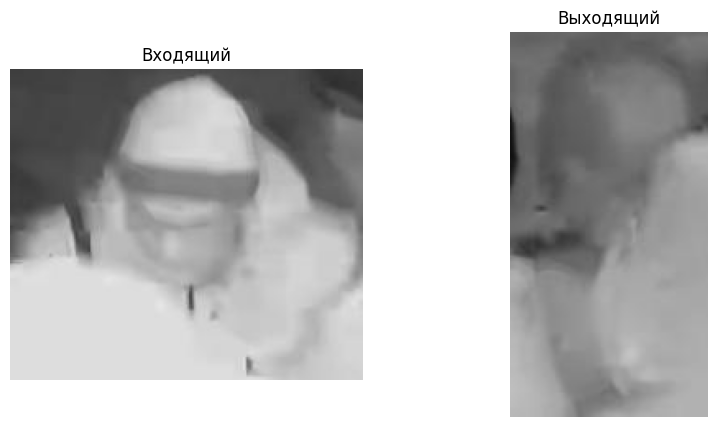

In [ ]:
# Создание заготовки для изображений всех классов
fig, axs = plt.subplots(1, CLASS_COUNT, figsize=(10, 5))

# Для всех номеров классов:
for i in range(CLASS_COUNT):

    # Формирование пути к папке содержимого класса
    car_path = f'{IMAGE_PATH}{CLASS_LIST[i]}/'

    # Выбор случайного фото из i-го класса
    img_path = car_path + random.choice(os.listdir(car_path))

    # Отображение фотографии (подробнее будет объяснено далее)
    axs[i].set_title(CLASS_LIST[i])
    axs[i].imshow(Image.open(img_path))
    axs[i].axis('off')

# Отрисовка всего полотна
plt.show()

In [ ]:
data_files = []                           # Cписок путей к файлам картинок
data_labels = []                          # Список меток классов, соответствующих файлам

for class_label in range(CLASS_COUNT):    # Для всех классов по порядку номеров (их меток)
    class_name = CLASS_LIST[class_label]  # Выборка имени класса из списка имен
    class_path = IMAGE_PATH + class_name  # Формирование полного пути к папке с изображениями класса
    class_files = os.listdir(class_path)  # Получение списка имен файлов с изображениями текущего класса
    print(f'Размер класса {class_name} составляет {len(class_files)} фото')

    # Добавление к общему списку всех файлов класса с добавлением родительского пути
    data_files += [f'{class_path}/{file_name}' for file_name in class_files]

    # Добавление к общему списку меток текущего класса - их ровно столько, сколько файлов в классе
    data_labels += [class_label] * len(class_files)

print()
print('Общий размер базы для обучения:', len(data_labels))

Размер класса Входящий составляет 6485 фото
Размер класса Выходящий составляет 2596 фото

Общий размер базы для обучения: 9081


In [ ]:
# ваше решение
# Теперь в списках находятся пути к файлам и соответствующие им номера классов:
print('Пути к файлам: ', data_files[6475:6490])
print('Их метки классов:', data_labels[6475:6490])

Пути к файлам:  ['/content/bus/Входящий/02563.jpg', '/content/bus/Входящий/05418.jpg', '/content/bus/Входящий/05468.jpg', '/content/bus/Входящий/00065.jpg', '/content/bus/Входящий/04781.jpg', '/content/bus/Входящий/00798.jpg', '/content/bus/Входящий/02068.jpg', '/content/bus/Входящий/01932.jpg', '/content/bus/Входящий/04435.jpg', '/content/bus/Входящий/06214.jpg', '/content/bus/Выходящий/01271.jpg', '/content/bus/Выходящий/01817.jpg', '/content/bus/Выходящий/01650.jpg', '/content/bus/Выходящий/00953.jpg', '/content/bus/Выходящий/01425.jpg']
Их метки классов: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]


Формирование набора данных из имеющейся базы

В результате выполнения кода получились два списка:

data_files - имена файлов картинок из датасета; data_labels - метки (номера) классов, соответствующие файлам картинок из первого списка. С их помощью можно сформировать набор для обучения.

Теперь вы можете использовать список путей к файлам для формирования списка уже самих картинок, преобразованных в массивы пикселей. Это можно сделать функцией np.array(). Предварительно, загрузив фотографии методом Image.open(), примените метод .resize(). Это необходимо, чтобы все фотографии, а значит, и массивы пикселей, были одного размера. Приведение всех картинок к одному общему размеру поможет собрать единый массив из всего датасета.

Импортируем необходимую библиотеку, задаем желаемые размеры изображений, подготавливаем пустой список. Схема действий следующая:

перебираем в цикле пути к файлам изображений; открываем каждое изображение; приводим изображение к заданному размеру; переводим изображение в числовой формат; присоединяем полученный массив к общему списку; переводим общий список изображений в numpy-массив; переводим общий список меток классов в numpy-массив.

In [ ]:
# Задание единых размеров изображений

IMG_WIDTH = 64                           # Ширина изображения
IMG_HEIGHT = 128                           # Высота изображения

In [ ]:
import numpy as np                        # Библиотека работы с массивами

data_images = []                          # Пустой список для данных изображений

for file_name in data_files:
    # Открытие и смена размера изображения
    img = Image.open(file_name).resize((IMG_WIDTH, IMG_HEIGHT))
    img_np = np.array(img)                # Перевод в numpy-массив
    data_images.append(img_np)            # Добавление изображения в виде numpy-массива к общему списку

x_data = np.array(data_images)            # Перевод общего списка изображений в numpy-массив
y_data = np.array(data_labels)            # Перевод общего списка меток класса в numpy-массив

print(f'В массив собрано {len(data_images)} фотографий следующей формы: {img_np.shape}')
print(f'Общий массив данных изображений следующей формы: {x_data.shape}')
print(f'Общий массив меток классов следующей формы: {y_data.shape}')

В массив собрано 9081 фотографий следующей формы: (128, 64, 3)
Общий массив данных изображений следующей формы: (9081, 128, 64, 3)
Общий массив меток классов следующей формы: (9081,)


Вы перевели изображения в тензоры, давайте посмотрим, в каком виде они сейчас хранятся в памяти, обратившись к первому из них по индексу:

In [ ]:
x_data[0]

array([[[203, 254, 254],
        [203, 255, 253],
        [203, 255, 252],
        ...,
        [227, 255, 254],
        [226, 255, 253],
        [226, 255, 253]],

       [[203, 255, 253],
        [203, 255, 253],
        [203, 255, 253],
        ...,
        [230, 255, 254],
        [230, 255, 254],
        [230, 255, 254]],

       [[203, 255, 253],
        [203, 255, 253],
        [203, 255, 253],
        ...,
        [234, 254, 253],
        [234, 255, 254],
        [235, 255, 254]],

       ...,

       [[ 28,   2,  12],
        [ 30,   0,  10],
        [ 34,   0,   7],
        ...,
        [ 37,  51,  75],
        [ 47,  59,  77],
        [ 49,  60,  81]],

       [[ 33,   3,  15],
        [ 32,   1,  11],
        [ 34,   0,   7],
        ...,
        [ 37,  47,  66],
        [ 47,  57,  73],
        [ 50,  59,  79]],

       [[ 33,   4,   9],
        [ 31,   1,   6],
        [ 32,   0,   5],
        ...,
        [ 40,  45,  63],
        [ 45,  51,  67],
        [ 48,  53,  72]]

Заметим, что это трехмерные тензоры. В каждой ячейке стоит значение интенсивности пикселя в диапазоне 0-255. Для лучшего обучения нейронной сети данные необходимо перевести в диапазон [0, 1].

Такая операция называется нормализацией (нормированием) данных. Есть разные способы, а в данном случае нам подойдет деление всех значений на 255. Это число является максимумом исходного диапазона, поэтому любое значение пикселя, разделенное на него, даст результат от 0 до 1.

In [ ]:
# Нормированние массива изображений
x_data = x_data / 255.

Теперь у вас есть полный набор данных для обучения нейронной сети!

Создание сверточной сети

In [ ]:
# Подключение нужных слоев из модуля tensorflow.keras.layers

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization

Скомпонуем рассмотренные в теоретической части слои, в комментариях детально распишем, каким образом меняется форма данных при прохождении через слои.

In [ ]:
# Создание модели последовательной архитектуры
model = Sequential()

# Первый сверточный блок
model.add(Conv2D(256, (3, 3), name='First_C', padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))  # (128,64,3) --> (128,64,256) меняется кол-во фильтров
model.add(BatchNormalization(name='First_B'))  # (128,64,256) --> (128,64,256) нет изменений

# Второй сверточный блок
model.add(Conv2D(256, (3, 3), name='Second_C', padding='same', activation='relu'))  # (128,64,256) --> (128,64,256) нет изменений
model.add(MaxPooling2D(pool_size=(3, 3), name='Second_M'))  # сжимает размер в три раза, с потерей, т.к. padding='valid', глубина не изм. (128,64,256) --> (42,21,256)

# Третий сверточный блок
model.add(Conv2D(256, (3, 3), name='Third_C', padding='same', activation='relu'))  # (42,21,256) --> (42,21,256) нет изменений
model.add(BatchNormalization(name='Third_B'))  # (42,21,256) --> (42,21,256) нет изменений
model.add(Dropout(0.2, name='Third_D'))  # (42,21,256) --> (42,21,256) нет изменений

# Четвертый сверточный блок
model.add(Conv2D(256, (3, 3), name='Fourth_C', padding='same', activation='relu'))  # (42,21,256) --> (42,21,256) нет изменений
model.add(MaxPooling2D(pool_size=(3, 3), name='Fourth_M'))  # сжимает размер в три раза, хотя padding='valid', потерь нет, т.к. делится нацело, глубина не изм. (42,21,256) --> (14,7,256)
model.add(Dropout(0.2, name='Fourth_D'))  # (14,7,256) --> (14,7,256) нет изменений

# Пятый сверточный блок
model.add(Conv2D(512, (3, 3), name='Fifth_D', padding='same', activation='relu'))  # (14,7,256) --> (14,7,512) меняется количество фильтров
model.add(BatchNormalization(name='Fifth_B'))  # (14,7,512) --> (14,7,512) нет изменений

# Шестой сверточный блок
model.add(Conv2D(1024, (3, 3), name='Sixth_C', padding='same', activation='relu'))  # (14,7,1024) --> (14,7,1024) меняется кол-во фильтров
model.add(MaxPooling2D(pool_size=(3, 3), name='Sixth_M'))  # сжимает размер в три раза, с потерей, т.к. padding='valid', глубина не изм. (14,7,1024) --> (4,2,1024)
model.add(Dropout(0.2, name='Sixth_D'))  # (4,2,1024) --> (4,2,1024) нет изменений

# Блок классификации
model.add(Flatten(name='Class_1'))  # слой преобразования многомерных данных в одномерные (4,2,1024) --> (4*2*1024) --> (8192)
model.add(Dense(2048, activation='relu', name='Class_2'))  # полносвязный слой, меняется кол-во нейронов (8192) --> (2048)
model.add(Dense(4096, activation='relu', name='Class_3'))  # полносвязный слой, меняется кол-во нейронов (2048) --> (4096)
model.add(Dense(CLASS_COUNT, activation='softmax', name='Class_4'))  # выходной полносвязный слой, кол-во нейронов = количество классов (4096) --> (2)

Запросим сводку по архитектуре сети и проверим, верны ли расчеты форм тензоров на выходе слоев:

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 First_C (Conv2D)            (None, 128, 64, 256)      7168      
                                                                 
 First_B (BatchNormalizatio  (None, 128, 64, 256)      1024      
 n)                                                              
                                                                 
 Second_C (Conv2D)           (None, 128, 64, 256)      590080    
                                                                 
 Second_M (MaxPooling2D)     (None, 42, 21, 256)       0         
                                                                 
 Third_C (Conv2D)            (None, 42, 21, 256)       590080    
                                                                 
 Third_B (BatchNormalizatio  (None, 42, 21, 256)       1024      
 n)                                                     

собралась мощная модель на 32 миллиона параметров.

Чтобы перейти к ее обучению, нужно скомпилировать нейронную сеть.

Укажите метод подсчета ошибки сети – loss, по значению которой указанный вами оптимизатор (optimizer) пересчитает веса модели.

Скорость обучения нейронной сети зависит от шага learning_rate. Если шаг мал, то обучение идёт медленно, но в процессе лучше достигается локальный минимум ошибки. Если шаг велик, то обучение идёт быстро, но оптимизатор может проскочить локальный минимум и значение ошибки будет колебаться. Целесообразно сначала задать learning_rate побольше, а затем, когда значение ошибки перестанет устойчиво снижаться, постепенно уменьшать learning_rate.

Дополнительная информация (База знаний УИИ - «Функции ошибок (loss)»)

Вы можете указать список метрик (metrics), которые, как и значение ошибки, позволят оценить прогресс обучения модели.

При указании метрики accuracy вы увидите точность модели в определении класса (долю верных ответов).

In [ ]:
# Подключение оптимизатора Adam
from tensorflow.keras.optimizers import Adam

# Компиляция модели
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

Функция потерь sparse_categorical_crossentropy, так же как и categorical_crossentropy, используется для классификации двух или более классов. Однако в первом случае ожидаются метки классов в виде дискретных номеров, а во втором случае - в виде векторов one-hot encoding.

In [ ]:
# Обучение модели сверточной нейронной сети подготовленных данных

store_learning = model.fit(x_data,  # ----------------- x_train, примеры набора данных
                           y_data,  # ----------------- y_train, метки примеров набора данных
                           validation_split=0.2,  # --- 0.2 - доля данных для валидационной (проверочной) выборки, 1-0.2=0.8 останется в обучающей
                           shuffle=True,  # ----------- перемешивание данных для равномерного обучения, соответствие экземпляра и метки сохраняется
                           batch_size=25,  # ---------- размер пакета, который обрабатывает нейронка перед одним изменением весов
                           epochs=15,  # -------------- epochs - количество эпох обучения
                           verbose=1)  # -------------- 0 - не визуализировать ход обучения, 1 - визуализировать

Epoch 1/15
291/291 [==============================] - 58s 198ms/step - loss: 0.0103 - accuracy: 0.9960 - val_loss: 0.1709 - val_accuracy: 0.9653
Epoch 2/15
291/291 [==============================] - 55s 190ms/step - loss: 0.0115 - accuracy: 0.9967 - val_loss: 0.4236 - val_accuracy: 0.9125
Epoch 3/15
291/291 [==============================] - 57s 197ms/step - loss: 0.0171 - accuracy: 0.9960 - val_loss: 0.2878 - val_accuracy: 0.9213
Epoch 4/15
291/291 [==============================] - 57s 197ms/step - loss: 0.0102 - accuracy: 0.9977 - val_loss: 0.2325 - val_accuracy: 0.9362
Epoch 5/15
291/291 [==============================] - 57s 196ms/step - loss: 0.0065 - accuracy: 0.9988 - val_loss: 0.1707 - val_accuracy: 0.9620
Epoch 6/15
291/291 [==============================] - 55s 191ms/step - loss: 0.0141 - accuracy: 0.9961 - val_loss: 0.2104 - val_accuracy: 0.9252
Epoch 7/15
291/291 [==============================] - 56s 191ms/step - loss: 0.0128 - accuracy: 0.9956 - val_loss: 0.4145 - val_ac

В переменную store_learning как результат метода обучения модели .fit() записалась история обучения, значения тех самых loss и accuracy на каждой эпохе обучения. Причем как для обучающей выборки, так и для проверочной.

Вы видели эти значения в распечатке по ходу обучения модели. По окончании обучения они записались в словарь store_learning.history.

Чтобы обратиться к этим данным в переменной store_learning, используем loss, val_loss, accuracy и val_accuracy в качестве ключей словаря. Далее с помощью методов из модуля matplotlib.pyplot покажем их в виде графиков.

Смотрите:

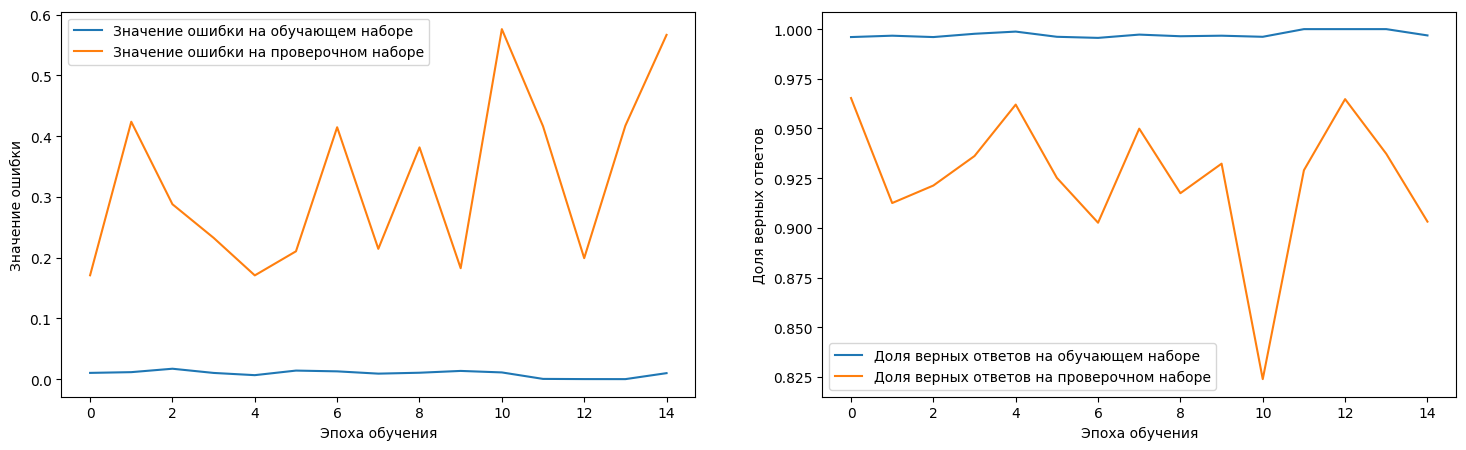

In [ ]:
# Создание полотна для рисунка
plt.figure(1, figsize=(18, 5))

# Задание первой (левой) области для построения графиков
plt.subplot(1, 2, 1)
# Отрисовка графиков 'loss' и 'val_loss' из значений словаря store_learning.history
plt.plot(store_learning.history['loss'],
         label='Значение ошибки на обучающем наборе')
plt.plot(store_learning.history['val_loss'],
         label='Значение ошибки на проверочном наборе')
# Задание подписей осей
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.legend()

# Задание второй (правой) области для построения графиков
plt.subplot(1, 2, 2)
# Отрисовка графиков 'accuracy' и 'val_accuracy' из значений словаря store_learning.history
plt.plot(store_learning.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(store_learning.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
# Задание подписей осей
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()

# Фиксация графиков и рисование всей картинки
plt.show()

По графикам хорошо видно, что данных для обучения вполне хватает, чтобы научить сеть классифицировать изображения из обучающего набора. Но ответы на проверочном наборе очень неравномерны, точность сильно колеблется.
Но задание выпролнено. Точность выше 90% на проверочной выборке достигнута.
На 5 эпохе можно было уже остановиться - максимальная точность на проверочной выборке: 96%.